In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import PIL.Image as Image
import math
from tqdm import tqdm
import time
from IPython.display import display, clear_output

c:\Users\user\anaconda3\envs\MAIN_ENV\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\user\anaconda3\envs\MAIN_ENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [95]:
# device that will be used on the whole ipynb
RUN_DEVICE = torch.device("cuda")

#                              convolution settings
#  ____________________________________|______________________________________
# |                                                                          |
# the conv kernel that will be applying the fast and innacurate "blooming", function: !!!ADD NAME LATER!!!
size = 3 # <- make sure odd number
sigma = 1
# chatgpt wrote this line idk what it is myself
mega_ultra_fask_kernel_weights = torch.tensor([[math.exp(-((i - size//2)**2 + (j - size//2)**2) / (2 * sigma**2)) for j in range(size)] for i in range(size)], dtype=torch.float32, device=RUN_DEVICE)
mega_ultra_fask_kernel = mega_ultra_fask_kernel_weights.repeat(1, 1, 1, 1)
mega_ultra_fast_padding = (mega_ultra_fask_kernel.shape[2] - 1) // 2

# the conv kernel that will be used in the function conv_bloom()
exact_ier_kernel_weights = torch.tensor([[1, 0.5, 1],
                                         [0.5, 0, 0.5],
                                         [1, 0.5, 1]], dtype=torch.float32, device=RUN_DEVICE)
exact_ier_kernel = exact_ier_kernel_weights.repeat(1, 1, 1, 1)
exact_ier_padding = (mega_ultra_fask_kernel.shape[2] - 1) // 2

In [3]:
# load png / jpg / whatever image from path to tensor
# should be self explanatory
def image_to_tensor(image_path):
    image = Image.open(image_path).convert('RGB')

    tensor_image = transforms.ToTensor()(image)
    tensor_image = tensor_image.to(RUN_DEVICE)

    return tensor_image

In [4]:
# take in tensor (like what function above returns)
# and display it with plt
def show_tensor_image(tensor_image):
    pil_image = transforms.ToPILImage()(tensor_image)
    plt.imshow(pil_image, cmap='gray')
    plt.show()

In [5]:
# function's purpose is to add "raytracer" - like noise
# that means darker regions get more noise         -1   <---------->   0   <---------->   1
# noise_goofy controlls the amount of noise:     no noise        normal noise        high noise
def add_fake_noise(image_tensor, noise_goofy=0):
    # avarage rgb channels to get how dark each pixel is
    dropout_prob_mask = torch.sum(image_tensor, dim=0) / 3
    # generate a random number for each pixel (from 0 to 1)
    random_decision_mask = torch.rand(dropout_prob_mask.shape, device=RUN_DEVICE)
    # check for each pixel if the random number generated passes the "dropout threshhold"
    # so basically if it doesnt pass: pixel is false (aka 0)
    dropout_mask = dropout_prob_mask - noise_goofy > random_decision_mask
    
    # multiply the true / false value of each pixel (it decides if it should be blackened or not) by the real image
    return dropout_mask == False, image_tensor * dropout_mask

In [6]:
# function is the simplest and slowest form of this "blooming" thing
# it literally just loops over all the pixels and changes the values manually
def loop_bloom(image_tensor, marked_for_denoising, unmarked_for_denoising):
    # image that comes in here is formatted like what image_to_tensor() function returns
    # it is shaped torch.Size([3, 32, 32]), and it is more comfortable for me to loop over it in shape torch.Size([32, 32, 3])
    image_tensor = image_tensor.permute(1, 2, 0)
    
    # this will hold the final result image (for the current bloom)
    result = torch.zeros(image_tensor.shape, dtype=torch.float32, device=RUN_DEVICE)  # Removed device specification
    
    # iterate over all possible pixels
    for y in range(image_tensor.shape[0]):
        for x in range(image_tensor.shape[1]):
            
            # target is the pixel we are currently focused on (so the color that we will be working on)
            # shaped: torch.Size([3, 3, 3]) -> rgb values
            target_pixel = image_tensor[y][x]
            
            # check if the current target pixel is NOT black
            if unmarked_for_denoising[0][y][x] == 1:
                # if its colorful, apply its color to the pixels that are surrounding it
                # (ONLY IF THEY ARE BLACK)
                # i think i put a try except here because shit was going out of range for the image tensor
                
                # center
                result[y][x] = target_pixel
                
                # Check and apply to neighboring pixels if they are within the image bounds
                if y + 1 < image_tensor.shape[0] and marked_for_denoising[0][y + 1][x] == 1:
                    result[y + 1][x] = target_pixel  # up
                
                if y - 1 >= 0 and marked_for_denoising[0][y - 1][x] == 1:
                    result[y - 1][x] = target_pixel  # down
                
                if x - 1 >= 0 and marked_for_denoising[0][y][x - 1] == 1:
                    result[y][x - 1] = target_pixel  # left
                
                if x + 1 < image_tensor.shape[1] and marked_for_denoising[0][y][x + 1] == 1:
                    result[y][x + 1] = target_pixel  # right
    
    # convert to format that is normaly used (reverse changes made in line 1)
    result = result.permute(2, 0, 1)
    
    return result

In [7]:
def conv_bloom(image_tensor, marked_for_denoising, unmarked_for_denoising):
    # Calculate black mask where black pixels are identified as 1 and colored pixels as 0
    black_mask = torch.all(image_tensor <= 0.1, dim=0).unsqueeze(0).float()

    # Apply convolution to each channel separately
    conv_results = []
    for channel in image_tensor:
        # Apply convolution only to black pixels
        conv_result = F.conv2d(channel.unsqueeze(0), mega_ultra_fask_kernel, padding=mega_ultra_fast_padding)
        # Mask out the convolution results with the black_mask
        masked_conv_result = conv_result * black_mask
        conv_results.append(masked_conv_result)

    # Concatenate the results along the channel dimension
    colored_result = torch.cat(conv_results, dim=0)

    # Normalize the result
    max_value = colored_result.abs().max()  # Get the maximum absolute value in the tensor
    normalized_colored_result = colored_result / max_value if max_value != 0 else colored_result

    # Final result is the sum of normalized colored result and the original image_tensor
    return normalized_colored_result + image_tensor

In [8]:
# this function is so smart your python interpreter might have trouble understanding it
def non_exact_conv_bloom(image_tensor, marked_for_denoising, unmarked_for_denoising, kernel=mega_ultra_fask_kernel, padding=mega_ultra_fast_padding):
    # explanation why goofy ahh channel split and not just conv over full image:
    # for some reason when i do it the normal way the image comes out black and white and this just works im not gonna fix it
    red_channel = image_tensor[0].unsqueeze(0)
    green_channel = image_tensor[1].unsqueeze(0)
    blue_channel = image_tensor[2].unsqueeze(0)
    
    # apply padding seperatly because i want to use "reflect" mode
    red_channel_padded = F.pad(red_channel, [padding] * 4, mode='reflect')
    green_channel_padded = F.pad(green_channel, [padding] * 4, mode='reflect')
    blue_channel_padded = F.pad(blue_channel, [padding] * 4, mode='reflect')
    
    # apply conv here
    red_conv = F.conv2d(red_channel_padded, kernel)
    green_conv = F.conv2d(green_channel_padded, kernel)
    blue_conv = F.conv2d(blue_channel_padded, kernel)
    
    # stack the channels back into a single image
    colored_result = torch.cat((red_conv, green_conv, blue_conv), dim=0)
    
    # this image is the new information that the function has generated
    black_fill = colored_result * marked_for_denoising
    
    # we want to normalize that because conv might return a bigger value than 1
    black_fill /= torch.max(black_fill)
    
    # original image is the image as if this function has never touched it
    # even reset previous of this function's edurations over it
    original_image = image_tensor * unmarked_for_denoising
    
    # place the progress of this function + all the functions before it on the original image
    return original_image + black_fill

In [9]:
def denoise(image_tensor, blooming_func, marked_for_denoising, unmarked_for_denoising, difference_tolerance_precent, movie=False, movie_fps=10):
    difference = difference_tolerance_precent + 1
    
    while difference > difference_tolerance_precent:
        movie_time_start = time.time()
        before_denoise = image_tensor
        image_tensor = blooming_func(image_tensor, marked_for_denoising, unmarked_for_denoising)
        difference = torch.sum(torch.abs(before_denoise - image_tensor)) / torch.prod(torch.tensor(image_tensor.shape)) * 100
        #marked_for_denoising = torch.all(image_tensor <= 0.2, dim=0).unsqueeze(0).to(torch.float32)
        #unmarked_for_denoising = (marked_for_denoising == 0).to(torch.float32)
        
        if movie:
            clear_output(wait=True)
            show_tensor_image(image_tensor)
            movie_time_end = time.time()
            
            # make sure that we wait the right amount of time before the next frame is drawn
            time.sleep(max(0, 1 / movie_fps - (movie_time_end - movie_time_start)))
    
    return image_tensor

original image:


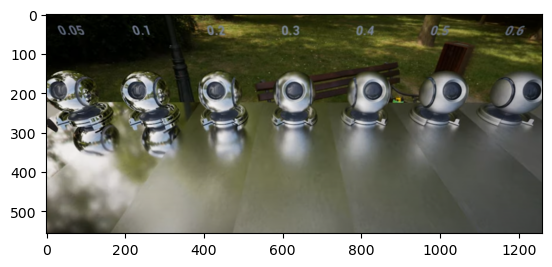

noisy image:


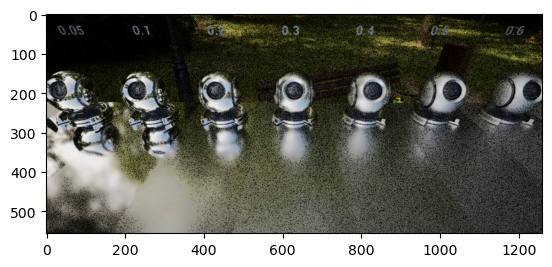

black pixels -> denoiser needs to guess:


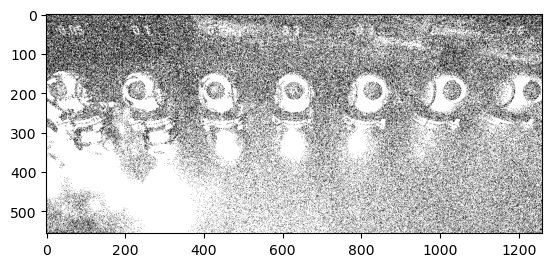

In [212]:
image = image_to_tensor(fr"path 2 img")

print("original image:")
show_tensor_image(image)

marked_for_denoising, image = add_fake_noise(image, noise_goofy=-0.4)
marked_for_denoising = marked_for_denoising.unsqueeze(0).to(torch.float32)
# use this instead if you want to mark all pitch black pixels as noise
#marked_for_denoising = torch.all(image == 0, dim=0).unsqueeze(0).to(torch.float32)
unmarked_for_denoising = (marked_for_denoising == 0).to(torch.float32)

print("noisy image:")
show_tensor_image(image)

print("black pixels -> denoiser needs to guess:")
show_tensor_image(unmarked_for_denoising)

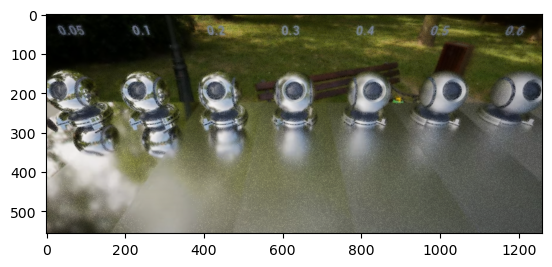

In [213]:
show_tensor_image(image)
clear_output(wait=True)
image = denoise(image, non_exact_conv_bloom, marked_for_denoising, unmarked_for_denoising, difference_tolerance_precent=1, movie=True, movie_fps=60)

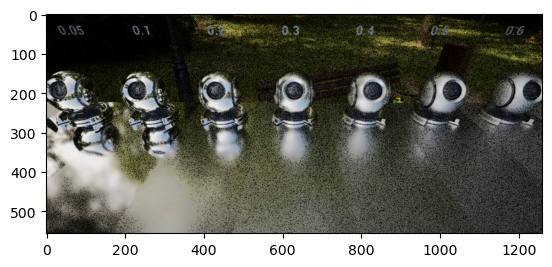

In [214]:
show_tensor_image(image * unmarked_for_denoising)

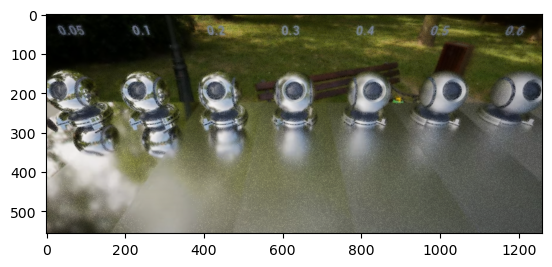

In [215]:
show_tensor_image(image)